In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
dati = "C:\\Users\\Riccardo\\Desktop\\Universita\\magistrale\\secondo anno\\Machine deep learning\\progettoML\\copia_drive\\dati\\flowers"
modelli = "C:\\Users\\Riccardo\\Desktop\\Universita\\magistrale\\secondo anno\\Machine deep learning\\progettoML\\copia_drive\\immagini\\modelli2"

In [ ]:
!pip install opencv-contrib-python==4.4.0.44

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


locale

colab

In [ ]:
dati = "/content/drive/MyDrive/ML/dati/flowers"
modelli = "/content/drive/MyDrive/ML/immagini/modelli2"
colab = True

In [ ]:
import sys
if colab:
    sys.path.insert(0,'/content/drive/MyDrive/ML/immagini/util')
else:
    sys.path.insert(0,'C:\\Users\\Riccardo\\Desktop\\Universita\\magistrale\\secondo anno\\Machine deep learning\\progettoML\\copia_drive\\immagini\\util')

In [ ]:
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import cv2 as cv
from sklearn.ensemble import AdaBoostClassifier
import os
from joblib import dump, load
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from matplotlib import image as mp_image
from sklearn.model_selection import train_test_split
if colab:
    from google.colab import drive
    from google.colab.patches import cv2_imshow
    from google.colab import files
from scipy.stats import skew, kurtosis
from sklearn.cluster import KMeans
from joblib import dump, load
from sklearn.multiclass import OneVsRestClassifier
import util
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
import tensorflow as tf
import keras
from functools import partial
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
import copy
from tensorflow.keras import layers, losses

In [ ]:
X, y = util.carica_foto(dati,(150,150),"cv")
X = np.array(X)
y = np.array(y)

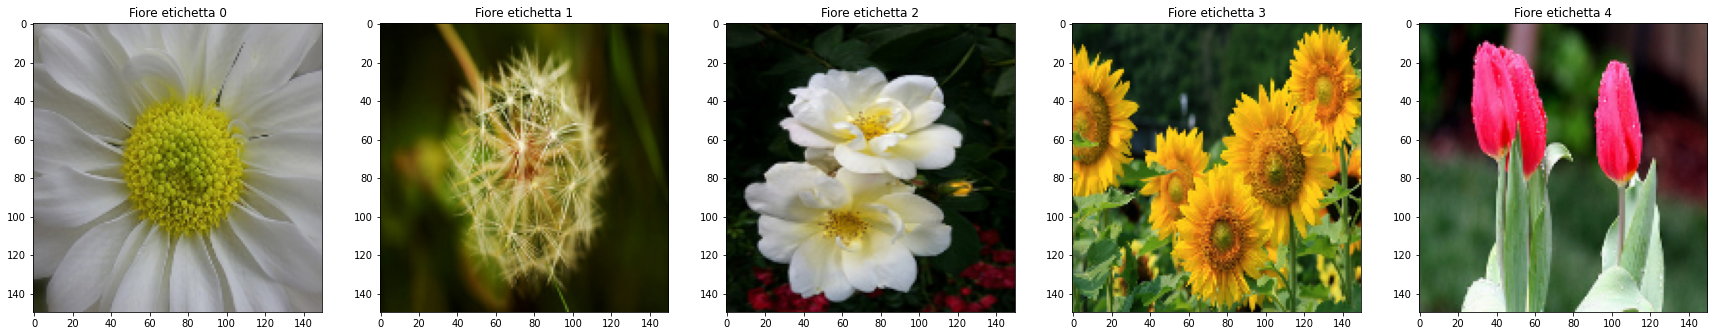

In [ ]:
fig = plt.figure(figsize=(30,10))
for i in range(5):
    idx = np.where(y == i)[0][0]
    img = copy.deepcopy(X[idx])
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    ax = fig.add_subplot(1,5,i+1)
    ax.set_title(f'Fiore etichetta {i}')
    ax.imshow(img)
plt.show()

In [ ]:
mapping = {0 : "daisy", 1 : "dandelion", 2 : "rose", 3 : "sunflower", 4 : "tulip"}

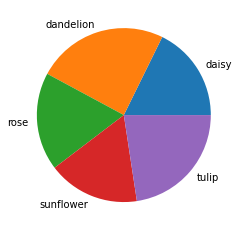

In [ ]:
labels = copy.deepcopy(y)
labels_singole = np.unique(labels)
conteggio = np.zeros(len(labels_singole))
for i,l in enumerate(labels_singole):
    n = len(np.where(labels == l)[0])
    conteggio[i] += n
vere_labels = []
for i in range(len(labels_singole)):
    vere_labels.append(mapping[labels_singole[i]])
plt.pie(conteggio, labels=vere_labels)
plt.show()

<h1>Estrazione features</h1>

<h2>Colori</h2>

In [ ]:
X_hsv = X.copy()
for i in range(len(X_hsv)):
    img = X_hsv[i]
    X_hsv[i] = cv.cvtColor(img, cv.COLOR_BGR2HSV)

In [ ]:
features_colori = np.zeros((X_hsv.shape[0],12))
for i in range(len(X_hsv)):
    img = X_hsv[i]
    media_hue = img[:, :, 0].mean()
    media_saturation = img[:, :, 1].mean()
    media_value = img[:, :, 2].mean()
    std_hue = img[:, :, 0].std()
    std_saturation = img[:, :, 1].std()
    std_value = img[:, :, 2].std()
    skewness_hue = skew(img[:, :, 0].flatten())
    skewness_saturation = skew(img[:, :, 1].flatten())
    skewness_value = skew(img[:, :, 2].flatten())
    kurtosis_hue = kurtosis(img[:, :, 0].flatten())
    kurtosis_saturation = kurtosis(img[:, :, 1].flatten())
    kurtosis_value = kurtosis(img[:, :, 2].flatten())
    features_colori[i] = np.array([media_hue, media_saturation, media_value,
                                 std_hue, std_saturation, std_value,
                                 skewness_hue, skewness_saturation, skewness_value,
                                kurtosis_hue, kurtosis_saturation, kurtosis_value])

<h2> SIFT

In [ ]:
X_gray = np.zeros((X.shape[0],150, 150))
for i in range(len(X)):
    X_gray[i] = cv.cvtColor(X[i],cv.COLOR_BGR2GRAY)

In [ ]:
sift = cv.SIFT_create()
X_sift = []
for i in range(len(X_gray)):
    kp, des = sift.detectAndCompute(X_gray[i].astype("uint8"), None)
    X_sift.append(des)
X_sift = np.array(X_sift)

C:\Users\Riccardo\AppData\Local\Temp\ipykernel_17840\1200629195.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_sift = np.array(X_sift)


<h2>Clustering

In [ ]:
X_clustering = []
for img in X_sift:
    for vettore in img:
        X_clustering.append(vettore)
X_clustering = np.array(X_clustering)

In [ ]:
X_clustering.shape

(926381, 128)

In [ ]:
kmeans = KMeans(n_clusters=1000, random_state=0, n_init=1).fit(X_clustering)

In [ ]:
dump(kmeans, os.path.join(modelli,"kmeans1000_2"))

['C:\\Users\\Riccardo\\Desktop\\Universita\\magistrale\\secondo anno\\Machine deep learning\\progettoML\\copia_drive\\immagini\\modelli2\\kmeans1000_2']

<h2>Creazione del BOVW

In [ ]:
kmeans = load(os.path.join(modelli,"kmeans1000_2"))
n_clusters = 1000
X_train = np.zeros((len(X), n_clusters+features_colori.shape[1]))
for i in range(len(X_sift)):
  descrittori_img = X_sift[i]
  k = np.zeros((n_clusters,))
  #centroidi_piu_vicini = kmeans.predict(descrittori_img.astype("double"))
  centroidi_piu_vicini = kmeans.predict(descrittori_img)
  for j in range(len(centroidi_piu_vicini)):
    k[centroidi_piu_vicini[j]] += 1
  k = k/len(descrittori_img)
  colore = features_colori[i]
  X_train[i] = np.concatenate((k,colore))

<h1>ML classico

In [ ]:
adaboost = OneVsRestClassifier(AdaBoostClassifier(n_estimators=5000))

In [ ]:
adaboost.fit(X_train, y)
adaboost.score(X_train, y)

0.9990671641791045

In [ ]:
dump(adaboost, os.path.join(modelli,'adaboost'))

['C:\\Users\\Riccardo\\Desktop\\Universita\\magistrale\\secondo anno\\Machine deep learning\\progettoML\\copia_drive\\immagini\\modelli2\\adaboost']

In [ ]:
scores1 = cross_val_score(adaboost, X_train, y, cv=10, n_jobs=-1, error_score='raise', verbose=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 205.1min remaining: 136.7min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 338.4min finished


In [ ]:
scores1

array([0.55477855, 0.5990676 , 0.55011655, 0.57808858, 0.56410256,
       0.57109557, 0.58741259, 0.55710956, 0.55140187, 0.61915888])

In [ ]:
np.mean(scores1)

0.5732332309435113

In [ ]:
svm = OneVsRestClassifier(SVC(C=1.75))

In [ ]:
svm.fit(X_train, y)
svm.score(X_train, y)

0.4904384328358209

In [ ]:
scores2 = cross_val_score(svm, X_train, y, cv=10, n_jobs=-1, error_score='raise', verbose=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  2.2min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.9min finished


In [ ]:
np.mean(scores2)

0.45591900311526484

In [ ]:
scores2

array([0.48717949, 0.48484848, 0.47319347, 0.46153846, 0.48951049,
       0.43589744, 0.4009324 , 0.43356643, 0.4182243 , 0.47429907])

In [ ]:
dump(svm, os.path.join(modelli,'svm'))

['C:\\Users\\Riccardo\\Desktop\\Universita\\magistrale\\secondo anno\\Machine deep learning\\progettoML\\copia_drive\\immagini\\modelli2\\svm']

In [ ]:
knn =  OneVsRestClassifier(KNeighborsClassifier(n_neighbors=31))

In [ ]:
knn.fit(X_train, y)
knn.score(X_train, y)

0.4974347014925373

In [ ]:
scores3 = cross_val_score(knn, X_train, y, cv=10, n_jobs=-1, error_score='raise', verbose=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    4.5s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.4s finished


In [ ]:
scores3

array([0.46620047, 0.46386946, 0.46620047, 0.4032634 , 0.45454545,
       0.41958042, 0.44755245, 0.41258741, 0.39252336, 0.45560748])

In [ ]:
np.mean(scores3)

0.4381930374921029

In [ ]:
dump(knn, os.path.join(modelli,'knn'))

['C:\\Users\\Riccardo\\Desktop\\Universita\\magistrale\\secondo anno\\Machine deep learning\\progettoML\\copia_drive\\immagini\\modelli2\\knn']

<h1> Prove

c:\users\riccardo\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


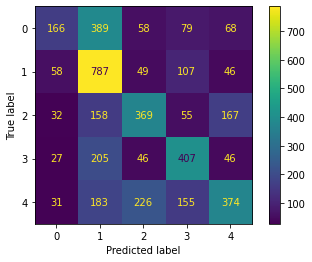

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(svm, X_train, y) 

<h1>Reti neurali

In [ ]:
X_normalizzato = X/255.0

ResNet34

In [ ]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1, padding="SAME", use_bias=False)
class ResidualUnit(keras.layers.Layer):
  def __init__(self, filters, strides=1, activation="relu", **kwargs):
    super().__init__(**kwargs)
    self.activation = keras.activations.get(activation)
    self.main_layers = [
      DefaultConv2D(filters, strides=strides),
      keras.layers.BatchNormalization(),
      self.activation,
      DefaultConv2D(filters),
      keras.layers.BatchNormalization()
    ]
    self.skip_layers = []
    if strides > 1:
      self.skip_layers = [
        DefaultConv2D(filters, kernel_size=1, strides=strides),
        keras.layers.BatchNormalization()
      ]

  def call(self, inputs):
    Z = inputs
    for layer in self.main_layers:
      Z = layer(Z)
    skip_Z = inputs
    for layer in self.skip_layers:
      skip_Z = layer(skip_Z)
    return self.activation(Z + skip_Z)
  
  #def get_config(self):
      #return {"a": self.var.numpy()}


model = keras.models.Sequential()
model.add(tf.keras.layers.Resizing(224, 224, interpolation='bilinear', crop_to_aspect_ratio=False))
model.add(DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
  strides = 1 if filters == prev_filters else 2
  model.add(ResidualUnit(filters, strides=strides))
  prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(5, activation="softmax"))

In [ ]:
model.compile(optimizer="adam", loss = keras.losses.sparse_categorical_crossentropy, metrics = ['accuracy'])

In [ ]:
history = model.fit(X, y, epochs = 35, batch_size = 64)

Epoch 1/35
67/67 [==============================] - 16s 165ms/step - loss: 1.5037 - accuracy: 0.4837
Epoch 2/35
67/67 [==============================] - 11s 166ms/step - loss: 1.0732 - accuracy: 0.5791
Epoch 3/35
67/67 [==============================] - 11s 167ms/step - loss: 0.9730 - accuracy: 0.6262
Epoch 4/35
67/67 [==============================] - 11s 167ms/step - loss: 0.9072 - accuracy: 0.6537
Epoch 5/35
67/67 [==============================] - 11s 166ms/step - loss: 0.8788 - accuracy: 0.6740
Epoch 6/35
67/67 [==============================] - 11s 166ms/step - loss: 0.7905 - accuracy: 0.7076
Epoch 7/35
67/67 [==============================] - 11s 164ms/step - loss: 0.7672 - accuracy: 0.7146
Epoch 8/35
67/67 [==============================] - 11s 165ms/step - loss: 0.7263 - accuracy: 0.7171
Epoch 9/35
67/67 [==============================] - 11s 165ms/step - loss: 0.7024 - accuracy: 0.7404
Epoch 10/35
67/67 [==============================] - 11s 165ms/step - loss: 0.6786 - accura

In [ ]:
sk.metrics.accuracy_score(y, np.argmax(model.predict(X), axis = -1))

0.949160447761194

Text(0, 0.5, 'accuracy')

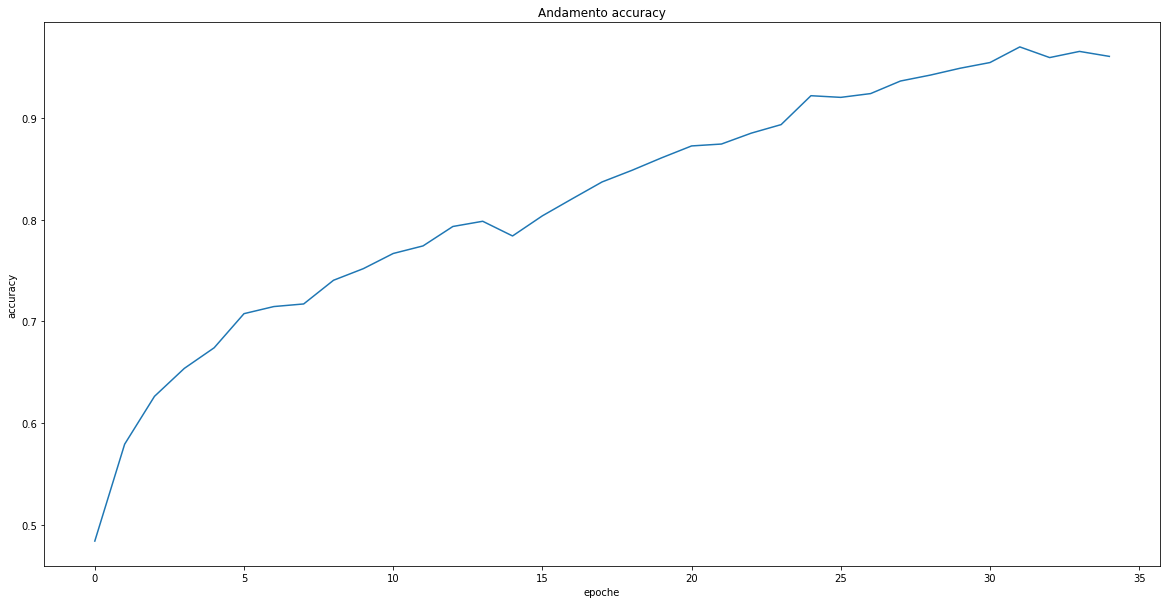

In [ ]:
fig, ax = plt.subplots(1,figsize=(20,10))
ax.plot(history.history['accuracy'])
ax.set_title("Andamento accuracy")
ax.set_xlabel("epoche")
ax.set_ylabel("accuracy")

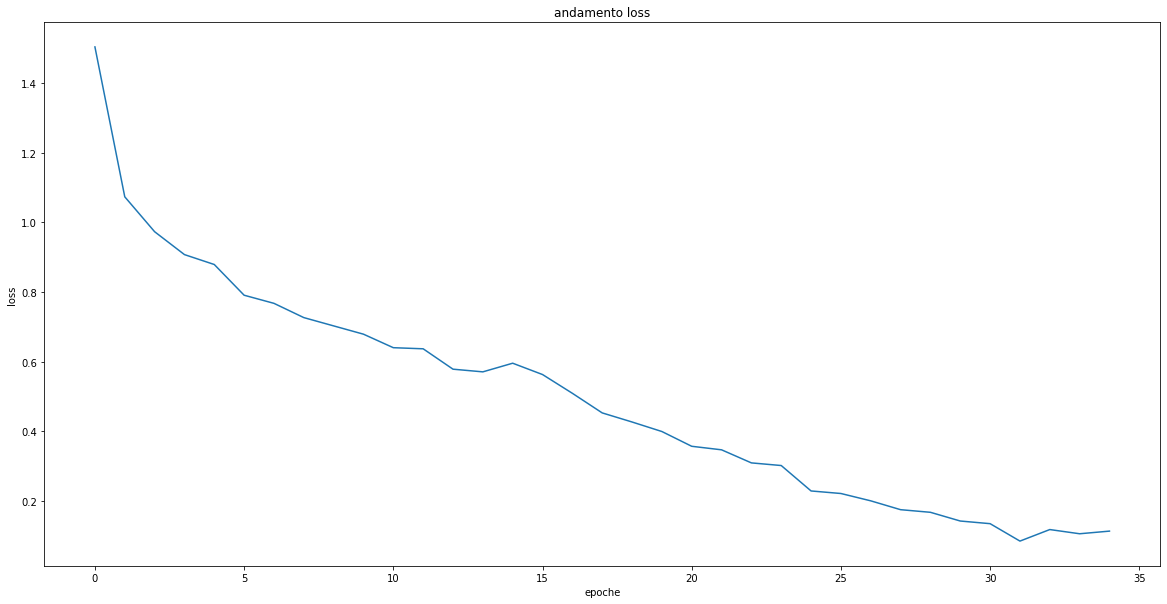

In [ ]:
fig, ax2 = plt.subplots(1, figsize = (20,10))
ax2.plot(history.history['loss'])
ax2.set_title("andamento loss")
ax2.set_xlabel("epoche")
ax2.set_ylabel("loss")
plt.show()

In [ ]:
class CNN(BaseEstimator, ClassifierMixin):
    def __init__(self):
        model = keras.models.Sequential()
        model.add(tf.keras.layers.Resizing(224, 224, interpolation='bilinear', crop_to_aspect_ratio=False))
        model.add(DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224, 224, 3]))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation("relu"))
        model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
        prev_filters = 64
        for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
          strides = 1 if filters == prev_filters else 2
          model.add(ResidualUnit(filters, strides=strides))
          prev_filters = filters
        model.add(keras.layers.GlobalAvgPool2D())
        model.add(keras.layers.Flatten())
        model.add(keras.layers.Dense(5, activation="softmax"))
        self.modello=model

    def fit(self, X, y):
        self.fitted = True
        batch_size = 64
        epochs = 35
        # Check that X and y have correct shape
        #X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        self.modello.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        self.X_ = X
        self.y_ = y
        # Return the classifier
        self.modello.fit(X, y,  epochs=epochs, batch_size=batch_size)
        return self

    def predict(self, X):
        # Check if fit has been called
        check_is_fitted(self)

        # Input validation
        #X = check_array(X)

        #closest = np.argmin(euclidean_distances(X, self.X_), axis=1)
        #return self.y_[closest]model.predict_classes(Xnew)
        return np.argmax(self.modello.predict(X), axis = -1)

In [ ]:
cnn = CNN()

In [ ]:
scores4 = cross_val_score(cnn, X, y, cv=10, error_score='raise', verbose=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/35
61/61 [==============================] - 15s 169ms/step - loss: 1.5672 - accuracy: 0.4644
Epoch 2/35
61/61 [==============================] - 10s 164ms/step - loss: 1.0629 - accuracy: 0.5867
Epoch 3/35
61/61 [==============================] - 10s 164ms/step - loss: 0.9340 - accuracy: 0.6390
Epoch 4/35
61/61 [==============================] - 10s 164ms/step - loss: 0.8734 - accuracy: 0.6688
Epoch 5/35
61/61 [==============================] - 10s 164ms/step - loss: 0.7951 - accuracy: 0.6999
Epoch 6/35
61/61 [==============================] - 10s 164ms/step - loss: 0.7719 - accuracy: 0.7111
Epoch 7/35
61/61 [==============================] - 10s 164ms/step - loss: 0.7540 - accuracy: 0.7201
Epoch 8/35
61/61 [==============================] - 10s 164ms/step - loss: 0.6803 - accuracy: 0.7473
Epoch 9/35
61/61 [==============================] - 10s 164ms/step - loss: 0.6712 - accuracy: 0.7556
Epoch 10/35
61/61 [==============================] - 10s 164ms/step - loss: 0.6382 - accura

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 59.5min finished


In [ ]:
scores4

array([0.6993007 , 0.74358974, 0.55244755, 0.68531469, 0.66899767,
       0.65501166, 0.77389277, 0.59207459, 0.5817757 , 0.69626168])

In [ ]:
np.mean(scores4)

0.664866675380694

In [ ]:
model.save(os.path.join(modelli,"cnn"))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/immagini/modelli2/cnn/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/immagini/modelli2/cnn/assets


prova

In [ ]:
model2 = keras.models.load_model(os.path.join(modelli,"cnn"))

In [ ]:
sk.metrics.accuracy_score(y, np.argmax(model2.predict(X), axis = -1))

0.949160447761194

<h1>Anomaly detection

la classe principale è quella più numerosa

In [ ]:
conteggio

array([ 760., 1047.,  781.,  731.,  969.])

In [ ]:
np.argmax(conteggio)

1

In [ ]:
mapping[np.argmax(conteggio)]

'dandelion'

..cioè dandelion

In [ ]:
X_anomaly_principale = copy.deepcopy(X[np.where(y==0)[0]])
X_anomaly_anomalie = copy.deepcopy(X[np.where(y!=0)[0]])
y_anomaly_principale = np.ones(len(X_anomaly_principale))
y_anomaly_anomalie = np.full(len(X_anomaly_anomalie), -1)
X_anomaly = np.concatenate((X_anomaly_principale,X_anomaly_anomalie))
y_anomaly = np.concatenate((y_anomaly_principale, y_anomaly_anomalie))

In [ ]:
ae = keras.models.Sequential()
ae.add(tf.keras.layers.Resizing(224, 224, interpolation='bilinear', crop_to_aspect_ratio=False))
ae.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
ae.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
ae.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
ae.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
ae.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
ae.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
ae.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
ae.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
ae.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
ae.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
ae.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
ae.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
ae.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
ae.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
#A questo punto abbiamo (14x14x512) ed è il bottleneck. Lo facciamo lungo 6 livelli
#-----------------------------INIZIO BOTTLENECK----------------------------------
ae.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
ae.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#ae.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#ae.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#ae.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#ae.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#----------------------------FINE BOTTLENECK--------------------------------------
#ora upsampling con convoluzione trasposta
ae.add(tf.keras.layers.Conv2DTranspose(filters = 512, kernel_size=(4,4), padding='same', strides=(2,2), activation='relu'))
#28
ae.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
ae.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
ae.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
ae.add(tf.keras.layers.Conv2DTranspose(filters = 256, kernel_size=(4,4), padding='same', strides=(2,2), activation='relu'))
#56
ae.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
ae.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
ae.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
ae.add(tf.keras.layers.Conv2DTranspose(filters = 128, kernel_size=(4,4), padding='same', strides=(2,2), activation='relu'))
#128
ae.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
ae.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
ae.add(tf.keras.layers.Conv2DTranspose(filters = 3, kernel_size=(4,4), padding='same', strides=(2,2), activation='relu'))
#224
#L'output è 224x224x3 ma lo riportiamo a 150x150x3
ae.add(tf.keras.layers.Resizing(150, 150, interpolation='bilinear', crop_to_aspect_ratio=False))


In [ ]:
ae.compile(loss=losses.MeanSquaredError(), optimizer='adam')

In [ ]:
history_anomaly = ae.fit(X_anomaly_principale, X_anomaly_principale, epochs = 105, batch_size = 64)

Epoch 1/105
12/12 [==============================] - 12s 874ms/step - loss: 19538870272.0000
Epoch 2/105
12/12 [==============================] - 10s 874ms/step - loss: 15857.2090
Epoch 3/105
12/12 [==============================] - 11s 876ms/step - loss: 15696.2539
Epoch 4/105
12/12 [==============================] - 10s 872ms/step - loss: 15773.3711
Epoch 5/105
12/12 [==============================] - 10s 873ms/step - loss: 15147.7109
Epoch 6/105
12/12 [==============================] - 10s 873ms/step - loss: 15815.9053
Epoch 7/105
12/12 [==============================] - 10s 872ms/step - loss: 14488.6621
Epoch 8/105
12/12 [==============================] - 10s 873ms/step - loss: 14107.4609
Epoch 9/105
12/12 [==============================] - 10s 873ms/step - loss: 15307.6885
Epoch 10/105
12/12 [==============================] - 10s 870ms/step - loss: 9996.0879
Epoch 11/105
12/12 [==============================] - 10s 872ms/step - loss: 6982.9795
Epoch 12/105
12/12 [=================

In [ ]:
history_anomaly2 = ae.fit(X_anomaly_principale, X_anomaly_principale, epochs = 35, batch_size = 64)

Epoch 1/35
12/12 [==============================] - 10s 872ms/step - loss: 4147.4956
Epoch 2/35
12/12 [==============================] - 10s 872ms/step - loss: 4031.4548
Epoch 3/35
12/12 [==============================] - 10s 875ms/step - loss: 3969.1443
Epoch 4/35
12/12 [==============================] - 10s 873ms/step - loss: 3962.3862
Epoch 5/35
12/12 [==============================] - 10s 872ms/step - loss: 3924.0171
Epoch 6/35
12/12 [==============================] - 10s 872ms/step - loss: 3911.3691
Epoch 7/35
12/12 [==============================] - 10s 873ms/step - loss: 3901.3838
Epoch 8/35
12/12 [==============================] - 10s 873ms/step - loss: 3872.0830
Epoch 9/35
12/12 [==============================] - 10s 874ms/step - loss: 3831.9431
Epoch 10/35
12/12 [==============================] - 10s 873ms/step - loss: 3087.5266
Epoch 11/35
12/12 [==============================] - 10s 873ms/step - loss: 3642.4260
Epoch 12/35
12/12 [==============================] - 10s 871ms/

In [ ]:
ae.save(modelli)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/immagini/modelli/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/immagini/modelli/assets


In [ ]:
history_anomaly3 = ae.fit(X_anomaly_principale, X_anomaly_principale, epochs = 50, batch_size = 64)

Epoch 1/50
12/12 [==============================] - 11s 873ms/step - loss: 2157.0381
Epoch 2/50
12/12 [==============================] - 10s 872ms/step - loss: 2133.1338
Epoch 3/50
12/12 [==============================] - 11s 876ms/step - loss: 2107.4424
Epoch 4/50
12/12 [==============================] - 11s 877ms/step - loss: 2088.5442
Epoch 5/50
12/12 [==============================] - 10s 873ms/step - loss: 2212.2793
Epoch 6/50
12/12 [==============================] - 10s 873ms/step - loss: 2204.5613
Epoch 7/50
12/12 [==============================] - 10s 871ms/step - loss: 2103.7903
Epoch 8/50
12/12 [==============================] - 10s 871ms/step - loss: 2060.6021
Epoch 9/50
12/12 [==============================] - 10s 872ms/step - loss: 2026.7118
Epoch 10/50
12/12 [==============================] - 10s 873ms/step - loss: 2009.7802
Epoch 11/50
12/12 [==============================] - 10s 873ms/step - loss: 1998.8668
Epoch 12/50
12/12 [==============================] - 10s 873ms/

In [ ]:
history_anomaly4 = ae.fit(X_anomaly_principale, X_anomaly_principale, epochs = 30, batch_size = 64)

Epoch 1/30
12/12 [==============================] - 10s 872ms/step - loss: 1393.7539
Epoch 2/30
12/12 [==============================] - 10s 873ms/step - loss: 1377.6736
Epoch 3/30
12/12 [==============================] - 11s 881ms/step - loss: 1343.3439
Epoch 4/30
12/12 [==============================] - 11s 882ms/step - loss: 1341.4111
Epoch 5/30
12/12 [==============================] - 10s 871ms/step - loss: 1339.9020
Epoch 6/30
12/12 [==============================] - 10s 872ms/step - loss: 1303.3441
Epoch 7/30
12/12 [==============================] - 10s 872ms/step - loss: 1295.5292
Epoch 8/30
12/12 [==============================] - 10s 874ms/step - loss: 1311.7678
Epoch 9/30
12/12 [==============================] - 10s 873ms/step - loss: 1275.7792
Epoch 10/30
12/12 [==============================] - 10s 872ms/step - loss: 1270.3140
Epoch 11/30
12/12 [==============================] - 10s 872ms/step - loss: 1248.3300
Epoch 12/30
12/12 [==============================] - 10s 873ms/

In [ ]:
ae.save(os.path.join(modelli,"ae"))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/immagini/modelli2/ae/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/immagini/modelli2/ae/assets


In [ ]:
ae_caricato = keras.models.load_model(os.path.join(modelli,"ae"))

In [ ]:
scores_anomaly = np.zeros(len(X_anomaly))
m = tf.keras.metrics.Mean()
for i,img in enumerate(X_anomaly):
  m.update_state((tf.square(ae_caricato(img.reshape((1,150,150,3)))-img)))
  scores_anomaly[i]=m.result().numpy()
  m.reset_state()

In [ ]:
scores_anomaly

array([1695.76367188,  474.73132324, 2673.60083008, ...,  609.0189209 ,
        758.36529541, 1085.42883301])

In [ ]:
scores_anomaly_normalizzati = scores_anomaly/np. linalg. norm(scores_anomaly)
scores_anomaly_normalizzati

array([0.01809392, 0.00506542, 0.02852752, ..., 0.00649828, 0.00809181,
       0.01158161])

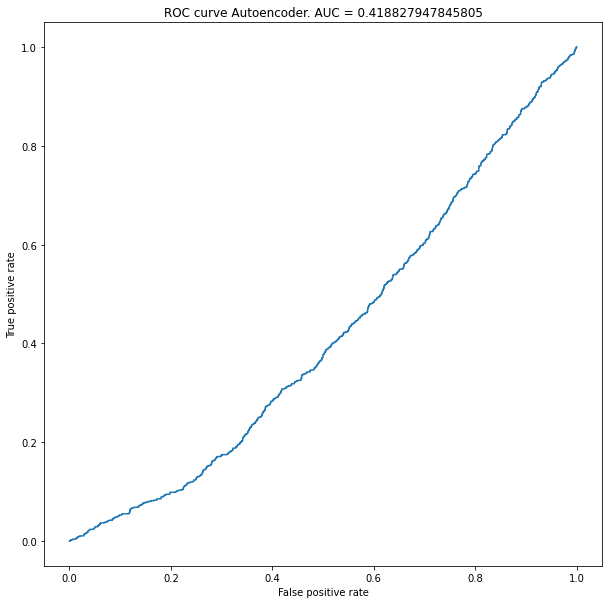

In [ ]:
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
fpr, tpr, thresholds = metrics.roc_curve(y_anomaly, scores_anomaly_normalizzati)
auc = metrics.auc(fpr, tpr)
fig, ax = plt.subplots(1, figsize = (10,10))
ax.plot(fpr,tpr)
ax.set_title(f"ROC curve Autoencoder. AUC = {auc}")
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
plt.show()

In [ ]:
X_train_anomaly_principale = copy.deepcopy(X_train[np.where(y==0)[0]])
X_train_anomaly_anomalie = copy.deepcopy(X_train[np.where(y!=0)[0]])
y_anomaly_principale = np.ones(len(X_train_anomaly_principale))
y_anomaly_anomalie = np.full(len(X_train_anomaly_anomalie), -1)
X_train_anomaly = np.concatenate((X_train_anomaly_principale,X_train_anomaly_anomalie))
y_anomaly = np.concatenate((y_anomaly_principale, y_anomaly_anomalie))

In [ ]:
from sklearn.svm import OneClassSVM
svm_anomaly = OneClassSVM(gamma='auto')
svm_anomaly.fit(X_train_anomaly_principale)

OneClassSVM(gamma='auto')

In [ ]:
scores_anomaly = svm_anomaly.score_samples(X_train_anomaly)

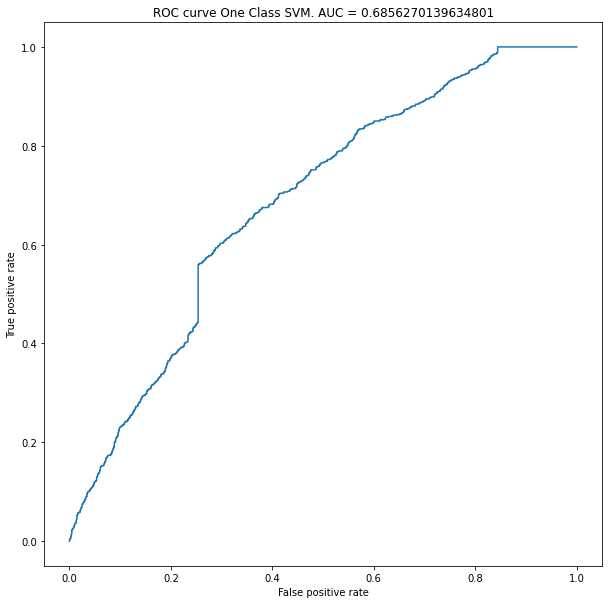

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_anomaly, scores_anomaly)
auc = metrics.auc(fpr, tpr)
fig, ax = plt.subplots(1, figsize = (10,10))
ax.plot(fpr,tpr)
ax.set_title(f"ROC curve One Class SVM. AUC = {auc}")
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
plt.show()

In [ ]:
dump(svm_anomaly, os.path.join(modelli,"svm_anomaly"))

['/content/drive/MyDrive/ML/immagini/modelli2/svm_anomaly']

In [ ]:
history_anomaly.history['loss']

{'loss': [520764129280.0,
  19867.1640625,
  14211.4462890625,
  13845.8017578125,
  10390.6220703125,
  8823.4345703125,
  7736.7548828125,
  7504.68115234375,
  7232.0244140625,
  6999.04248046875,
  6815.78857421875,
  6719.50634765625,
  6660.70947265625,
  6630.72607421875,
  6628.310546875,
  6624.34033203125,
  6548.02685546875,
  6532.12255859375,
  6504.861328125,
  6549.23486328125,
  6487.0498046875,
  6469.34326171875,
  6428.13427734375,
  9397.5166015625,
  30404.90625,
  13359.38671875,
  12741.638671875,
  29431.779296875,
  16722.369140625,
  14190.55078125,
  14190.064453125,
  14107.78515625,
  13432.84375,
  13425.7236328125,
  8503.064453125]}

In [ ]:
history_anomaly_totale = {}
history_anomaly_totale['loss']=history_anomaly.history['loss'] + history_anomaly2.history['loss'] + history_anomaly3.history['loss']+ history_anomaly4.history['loss']

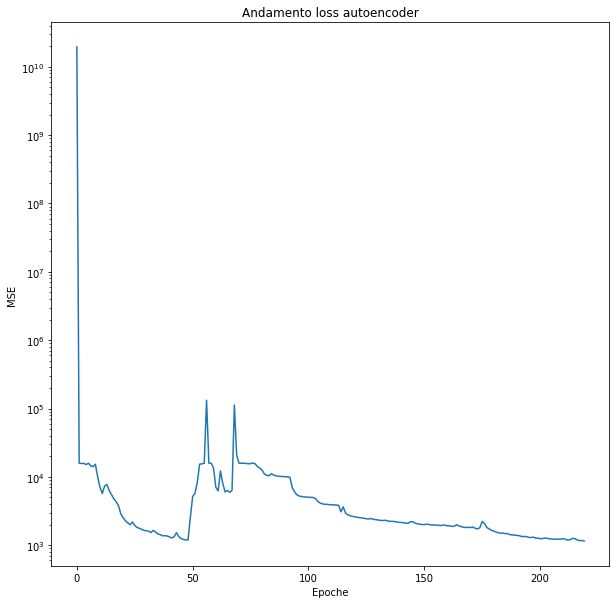

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax.plot(history_anomaly_totale['loss'])
ax.set_yscale('log')
ax.set_title("Andamento loss autoencoder")
ax.set_xlabel('Epoche')
ax.set_ylabel('MSE')
plt.show()